In [11]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('wordnet') # added MGW
from autocorrect import Speller
from nltk.corpus import stopwords   

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package wordnet to /Users/mgw/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Import the Data

In [2]:
df = pd.read_csv('Data/final_data.csv', header=None)
# df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

## Exploring the Data

In [3]:
# Printing unique category
df[1].unique()

array(['positive', 'imperative', 'interrogative', 'miscellaneous',
       'corrective', 'negative'], dtype=object)

In [4]:
# removing duplicate rows
# df = df.drop_duplicates()
df.duplicated().any()

True

In [5]:
# Checking null values
df.isnull().sum()

0    0
1    0
dtype: int64

In [6]:
# Checking the shape of the data
df.shape

(10000, 2)

## Preprocessing

In [7]:
# Preprocessing

# lowercasing
df[0] = df[0].str.lower()

# removing urls
df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)

# removing new lines "\n"
df[0] = df[0].str.replace('\n',' ', regex=True)

# removing all the punctuations
df[0] = df[0].str.replace('[^\w\s]',' ')

# removing integers
df[0] = df[0].str.replace('\d','', regex=True)

# removing emojis
df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)
df

/var/folders/f7/7wm8ypsx1_zcy_df6_f5nrl40000gn/T/ipykernel_16808/238825019.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)
/var/folders/f7/7wm8ypsx1_zcy_df6_f5nrl40000gn/T/ipykernel_16808/238825019.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('[^\w\s]',' ')
/var/folders/f7/7wm8ypsx1_zcy_df6_f5nrl40000gn/T/ipykernel_16808/238825019.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)


,0,1
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on udemy you ar...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,miscellaneous
...,...,...
9995,this is gold absolute peach of a video but i...,positive
9996,this is helpful how to decode a logical conte...,interrogative
9997,wow reading this slowly actually helped me se...,positive
9998,great video sir really helped a lot keep goin...,positive


In [8]:
# df.rename(columns={'comment':0, 'category':1}, inplace=True)
# df

In [9]:
# correcting the typos

spell = Speller(lang='en')

def typo_corrector(text):
    return spell(text)

df[0] = df[0].apply(typo_corrector)
df[0]

0                                          love you sir  
1       please make videos on  midpoint circle drawing...
2       i bought both of your courses on dmy  you are ...
3       thank you very much  u really got me in the fi...
4       i hope u are ok with everything going on again...
                              ...                        
9995    this is gold  absolute peach of a video  but i...
9996    this is helpful  how to decode a logical conte...
9997    wow  reading this slowly actually helped me se...
9998    great video sir  really helped a lot keep goin...
9999    oh damn  u deserve a lot many subscribers than...
Name: 0, Length: 10000, dtype: object

In [12]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df[0] = df[0].apply(lemmatize_text)
df

# # # stemming
# stemmer = nltk.stem.SnowballStemmer('english')
# def stem_text(text):
#     return stemmer.stem(text)

# df[0] = df[0].apply(stem_text)
# df

# lemmatizing

# nltk.download('wordnet')



,0,1
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on dmy you are ...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,miscellaneous
...,...,...
9995,this is gold absolute peach of a video but i...,positive
9996,this is helpful how to decode a logical conte...,interrogative
9997,wow reading this slowly actually helped me se...,positive
9998,great video sir really helped a lot keep goin...,positive


In [13]:
# Removing stopwords
# nltk.download('stopwords')

stop = stopwords.words('english')

# These are the words that should not be removed from their category
negative_words = ['no','not']
interrogative_words = ['how','what','which','who','whom','why','do','does','is','are','was','were','will','am',
                      'are','could','would','should','can','did','does','do','had','have']
imperative_words = ['could','would','should','can']

for_negative_category = stop.copy()
for word in negative_words:
    if word in for_negative_category:
        for_negative_category.remove(word)
    
for_interrogative_category = stop.copy()
for word in interrogative_words:
    if word in for_interrogative_category:
        for_interrogative_category.remove(word)
    
for_imperative_category = stop.copy()
for word in imperative_words:
    if word in for_imperative_category:
        for_imperative_category.remove(word)

# For negative category
for i in range(len(df)):
    if df[1][i] == "negative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_negative_category])

# For interrogative category
for i in range(len(df)):
    if df[1][i] == "interrogative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_interrogative_category])
        
# For interrogative category
for i in range(len(df)):
    if df[1][i] == "imperative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_imperative_category])
        
# For all other category
for i in range(len(df)):
    if df[1][i] == "positive" or df[1][i] == "correction" or df[1][i] == "other":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in stop])

# df[0] = df[0].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# df

In [14]:
# from wordcloud import WordCloud
# text = df[0].values 

# wordcloud = WordCloud(background_color='white',collocations=False).generate(str(text))

# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

## Feature Extaction

In [15]:
df.shape

(10000, 2)

In [16]:
import math 

N_occurance = 5

words = [df[0][i].split() for i in range(len(df))]
bag_of_words = sorted(list({word for list_ in words for word in list_}))
word_count = {word:0 for word in bag_of_words}
for word in bag_of_words:
    for list_ in words:
        if word in list_:
            word_count[word]+=1
filtered_words = [k for k,v in word_count.items() if v>N_occurance]
evaluation = np.zeros((len(df),len(filtered_words)))
for i in range(len(words)):
    counter = Counter(words[i])
    for k, v in counter.items():
        if k not in filtered_words:
            continue
        count = [1 for list_ in words if k in list_]
        evaluation[i][filtered_words.index(k)] = sum(count)/len(words)

# print(filtered_words)
evaluation.shape

(10000, 2210)

In [17]:
# features = evaluation
# features

In [18]:
from sklearn import preprocessing
# features = preprocessing.normalize(evaluation, norm='l2')
# features

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# features = scaler.fit_transform(evaluation)

min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(evaluation)

# scaler = preprocessing.RobustScaler()
# features = scaler.fit_transform(evaluation)


In [19]:
type(evaluation)

numpy.ndarray

## Applying models and calculating the scores

In [20]:
# Applying models

labels = df[1]
models = [
    RandomForestClassifier(max_features='log2', n_estimators=1000, criterion = 'entropy', 
                           random_state = 0),
    LinearSVC(C=1.0, random_state=0),
    MultinomialNB(alpha=1, fit_prior=True),
    LogisticRegression(C=1.0, penalty='l2', solver='newton-cg', random_state = 0),
    DecisionTreeClassifier(criterion='gini', 
                           max_features=None,min_samples_leaf=1, 
                           min_samples_split=2, random_state=0),
]

cv_df = pd.DataFrame()
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=10)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])



ModuleNotFoundError: No module named 'seaborn'

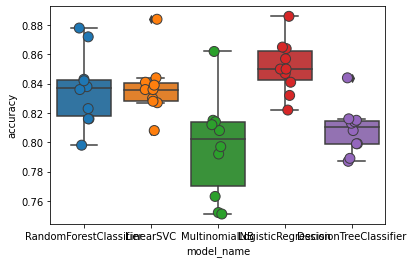

In [21]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, linewidth=1)
plt.show()

In [22]:
# Printing the accuracies
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.8084
LinearSVC                 0.8373
LogisticRegression        0.8514
MultinomialNB             0.7966
RandomForestClassifier    0.8362
Name: accuracy, dtype: float64

In [23]:
features.shape

(10000, 2210)

## Appyling other models

In [24]:
X = features
y = df.iloc[:, 1].values
indices = range(len(X))

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices,
                                                                                 test_size=0.2, random_state=42)

In [26]:
# for scatter plot -> at the bottom

# # Function to show the accuracy of each class
# def acc_each_class(cf_matrix):
#     total_comments = cf_matrix.sum(axis=1)
#     correctly_classified = np.diagonal(cf_matrix)
#     incorrectly_classified = total_comments-correctly_classified
    
#     accuracy_each_class = correctly_classified/total_comments
#     return accuracy_each_class
#     return total_comments, correctly_classified, incorrectly_classified

In [27]:
# Function to show original category vs predicted category

def show_prediction(y_pred, y_test):

    indices_match = y_pred == y_test

    df = pd.read_csv('Data/final_data.csv', header=None)

    get_comments = []

    for i in range(len(indices_test)):
        get_comments.append(df[0][indices_test[i]])


    data = list(zip(get_comments, y_test, y_pred))
    df_result = pd.DataFrame(data, columns=["comment", "original class", "predicted class"])
    return df_result

In [28]:
# Multinomial NB
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB(alpha=1, fit_prior=True)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_mnb = confusion_matrix(y_test, y_pred)


print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.8485


In [29]:
# accuracies = acc_each_class(cm)

# acc_corrective.append(accuracies[0])
# acc_imperative.append(accuracies[1])
# acc_interrogative.append(accuracies[2])
# acc_miscellaneous.append(accuracies[3])
# acc_negative.append(accuracies[4])
# acc_positive.append(accuracies[5])

In [60]:
# ### Hyperparameter Tuning ###

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# # from sklearn.ensemble import MultinomialNB

# # define models and parameters
# model = MultinomialNB()
# fit_prior=[True, False]
# alpha=[0,0.5,1]

# # define grid search
# grid = dict(fit_prior=fit_prior,alpha=alpha)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_   jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

/Users/mgw/opt/anaconda3/envs/CS680/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/mgw/opt/anaconda3/envs/CS680/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/mgw/opt/anaconda3/envs/CS680/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/mgw/opt/anaconda3/envs/CS680/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/mgw/opt/anaconda3/envs/CS680/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/mgw/opt/anaconda3/envs/CS680

Best: 0.834375 using {'alpha': 1, 'fit_prior': True}
0.792083 (0.010701) with: {'alpha': 0, 'fit_prior': True}
0.759542 (0.012406) with: {'alpha': 0, 'fit_prior': False}
0.834250 (0.011729) with: {'alpha': 0.5, 'fit_prior': True}
0.796833 (0.014178) with: {'alpha': 0.5, 'fit_prior': False}
0.834375 (0.010891) with: {'alpha': 1, 'fit_prior': True}
0.808417 (0.011502) with: {'alpha': 1, 'fit_prior': False}


In [31]:
# show_prediction(y_pred, y_test)

In [1]:
# Linear SVC
from sklearn.svm import SVC

classifier = SVC(C=1.0, gamma='scale', kernel='linear', random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_lsvc = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

NameError: name 'X_train' is not defined

In [33]:
# accuracies = acc_each_class(cm)

# acc_corrective.append(accuracies[0])
# acc_imperative.append(accuracies[1])
# acc_interrogative.append(accuracies[2])
# acc_miscellaneous.append(accuracies[3])
# acc_negative.append(accuracies[4])
# acc_positive.append(accuracies[5])

In [34]:
# ### Hyperparameter Tuning ###

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# # define model and parameters
# model = SVC()
# kernel = ['linear','poly', 'rbf', 'sigmoid']
# C = [50, 10, 1.0, 0.1, 0.01]
# gamma = ['scale']
# # define grid search
# grid = dict(kernel=kernel,C=C,gamma=gamma)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [35]:
# show_prediction(y_pred, y_test)

In [36]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(C=1.0, penalty='l2', solver='newton-cg', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.871


In [37]:
cm_lr

array([[  8,   0,   2,  10,   1,   0],
       [  0, 151,  18,   3,   5,  43],
       [  0,  18, 581,   5,   2,  17],
       [  5,   0,   9, 296,   1,  17],
       [  0,   2,   1,  12,  60,  37],
       [  0,  14,   1,  31,   4, 646]])

In [38]:
# accuracies = acc_each_class(cm_lr)

# acc_corrective.append(accuracies[0])
# acc_imperative.append(accuracies[1])
# acc_interrogative.append(accuracies[2])
# acc_miscellaneous.append(accuracies[3])
# acc_negative.append(accuracies[4])
# acc_positive.append(accuracies[5])

In [39]:
# ### Hyperparameter Tuning ###

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression

# # define models and parameters
# model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l1', 'l2', 'elasticnet', 'none']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [40]:
# show_prediction(y_pred, y_test)

In [41]:
# # Naive Bayes
# from sklearn.naive_bayes import GaussianNB

# classifier = GaussianNB()
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)

# print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [42]:
# # KNN
# from sklearn.neighbors import KNeighborsClassifier

# classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm_knn = confusion_matrix(y_test, y_pred)

# print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [43]:
# # Kernal SVC RBF

# classifier = SVC(kernel = 'rbf', random_state = 0)
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm_k_svc = confusion_matrix(y_test, y_pred)

# print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [44]:
# # Kernal SVC sigmoid

# classifier = SVC(kernel = 'sigmoid', random_state = 0)
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)

# print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [45]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier = RandomForestClassifier(max_features='log2', n_estimators=1000, criterion = 'entropy', random_state = 0)

classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.85


In [46]:
# accuracies = acc_each_class(cm_rf)

# acc_corrective.append(accuracies[0])
# acc_imperative.append(accuracies[1])
# acc_interrogative.append(accuracies[2])
# acc_miscellaneous.append(accuracies[3])
# acc_negative.append(accuracies[4])
# acc_positive.append(accuracies[5])

In [47]:
# ### Hyperparameter Tuning ###

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # define models and parameters
# model = RandomForestClassifier()
# n_estimators = [10, 100, 1000]
# max_features = ['sqrt', 'log2']
# criterion = ['gini', 'entropy']
# # define grid search
# grid = dict(n_estimators=n_estimators,max_features=max_features,criterion=criterion)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [48]:
# # Show falsely predicted comments

# def show_neg_prediction(y_pred, y_test):

#     indices_match = y_pred == y_test

#     df = pd.read_csv('Scrapper/final.csv', header=None)

#     get_comments = []

#     for i in range(len(indices_test)):
#         if indices_match[i] == False:
#             get_comments.append(df[0][indices_test[i]])


#     data = list(zip(get_comments, y_test, y_pred))
#     df_result = pd.DataFrame(data, columns = ["comment", "original class", "predicted class"])
#     return df_result

In [49]:
# df_ = show_prediction(y_pred, y_test)
# pd.options.display.max_colwidth = 150
# df_.iloc[200:250]


In [50]:
# Decision Tree
# from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_features=None,min_samples_leaf=1, 
                                    min_samples_split=2, random_state=0)
# classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.835


In [51]:
# accuracies = acc_each_class(cm_dt)

# acc_corrective.append(accuracies[0])
# acc_imperative.append(accuracies[1])
# acc_interrogative.append(accuracies[2])
# acc_miscellaneous.append(accuracies[3])
# acc_negative.append(accuracies[4])
# acc_positive.append(accuracies[5])

In [52]:
# from sklearn import tree
# tree.export_graphviz(classifier, out_file='tree.dot') 
# tree.plot_tree(classifier)

In [53]:
# ### Hyperparameter Tuning ###

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV

# # define models and parameters
# model = DecisionTreeClassifier()
# max_features = ['sqrt', 'log2', 'auto']
# criterion = ['gini', 'entropy']
# max_depth = [2,4,6,8,10,12]
# min_samples_split = range(1,10)
# min_samples_leaf = range(1,5)
# # define grid search
# grid = dict(max_depth=max_depth,max_features=max_features,criterion=criterion,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [54]:
# show_prediction(y_pred, y_test)

## Histogram

In [55]:
def acc_each_category(cf_matrix):
#     total_comments = cf_matrix.sum(axis=1)
    correctly_classified = np.diagonal(cf_matrix)
    return correctly_classified

y = cm_dt.sum(axis=1)

In [56]:
z1 = acc_each_category(cm_lsvc)
z2 = acc_each_category(cm_lr)
z3 = acc_each_category(cm_mnb)
z4 = acc_each_category(cm_rf)
z5 = acc_each_category(cm_dt)

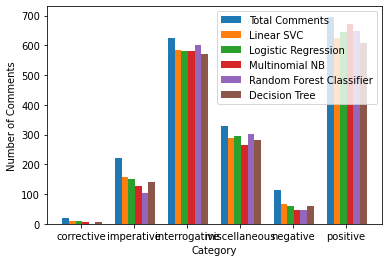

In [57]:
import matplotlib.pyplot as plt

x_tick = np.unique(y_test)
w = 0.125
x1 = np.array([1,2,3,4,5,6])
x2 = x1+w
x3 = x2+w
x4 = x3+w
x5 = x4+w
x6 = x5+w
x7 = x6+w

plt.xticks(ticks=x1+0.3, labels=x_tick)
plt.bar(x1, y, w, label = "Total Comments")
plt.bar(x2, z1, w, label = "Linear SVC")
plt.bar(x3, z2, w, label = "Logistic Regression",)
plt.bar(x4, z3, w, label = "Multinomial NB",)
plt.bar(x5, z4, w, label = "Random Forest Classifier")
plt.bar(x6, z5, w, label = "Decision Tree")


plt.rcParams["figure.figsize"] = (15,5)
plt.xlabel("Category")
plt.ylabel("Number of Comments")
plt.legend()
plt.show()

## Percentage of accuracy in each class

In [58]:
corr = [i * 100 for i in acc_corrective]
imp = [i * 100 for i in acc_imperative]
inte = [i * 100 for i in acc_interrogative]
mis = [i * 100 for i in acc_miscellaneous]
neg = [i * 100 for i in acc_negative]
pos = [i * 100 for i in acc_positive]

NameError: name 'acc_corrective' is not defined

In [59]:
import matplotlib.pyplot as plt

# x1 = [10,20,30,40,50]
x1 = ['Linear SVC','Logistic Regression','Multinomial NB','Random Forest Classifier','Decision Tree Classifier']
# corrective
y1 = corr
# plotting the line 1 points 
plt.plot(x1, y1, label = "Corrective", marker='o')

# imperative
y2 = imp
# plotting the line 2 points 
plt.plot(x1, y2, label = "Imperative", marker='*')

# interrogative
y3 = inte
# plotting the line 2 points 
plt.plot(x1, y3, label = "Interrogative", marker='s')

# Miscellaneous
y4 = mis
# plotting the line 2 points 
plt.plot(x1, y4, label = "Miscellaneous", marker='.')

# Negative
y5 = neg
# plotting the line 2 points 
plt.plot(x1, y5, label = "Negative", marker='^')

# Positive
y6 = pos
# plotting the line 2 points 
plt.plot(x1, y6, label = "Positive", marker='+')


plt.xlabel('')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy Percentage')
# Set a title of the current axes.
plt.title('')
# show a legend on the plot
plt.legend()

plt.xticks(rotation=90)
# Display a figure.
plt.show()

NameError: name 'corr' is not defined

## Plotting accuracy vs data size

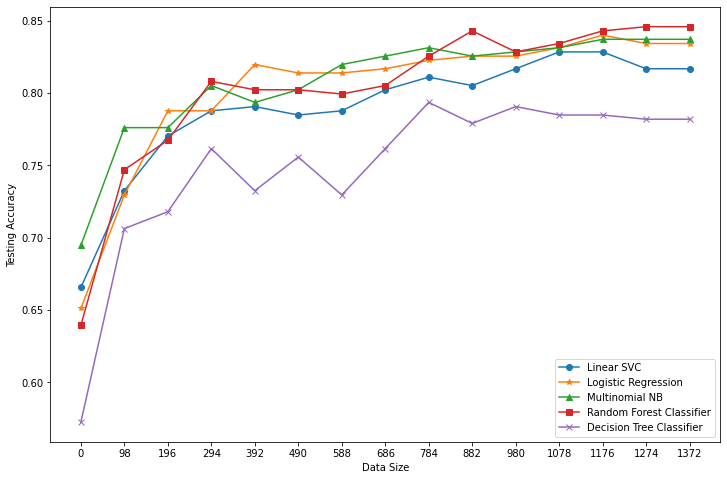

In [ ]:
def plot_acc_curve(classifier, linestyle, label):    
    
    num_of_splits = 14
    each_split_size = len(X_train)//num_of_splits

    each_split = 98
    scores = []

    for i in range(num_of_splits+1):
        split_X_train = X_train[0:each_split]
        split_y_train = y_train[0:each_split]

        each_split += each_split_size

        classifier.fit(split_X_train, split_y_train)
        scores.append(classifier.score(X_test, y_test))
    
    m = 14
    n = 98
    x_splits = list(range(0, (m+1)*n, n))

    plt.xlabel('Data Size')
    plt.ylabel('Testing Accuracy')
    plt.plot(x_splits, scores, linestyle, label = label)
    plt.xticks(x_splits)
    plt.legend(loc="best")
    
    return plt
    

plt.figure(figsize=(12,8))

# Linear SVC
classifier = SVC(C=1.0, gamma='scale', kernel='linear', random_state=0)
plot_acc_curve(classifier, linestyle = 'o-', label="Linear SVC")

# Logistic Regression
classifier = LogisticRegression(C=1.0, penalty='l2', solver='newton-cg', random_state = 0)
plot_acc_curve(classifier, linestyle = '*-', label="Logistic Regression")

# Multinomial NB
classifier = MultinomialNB(alpha=1, fit_prior=True)
plot_acc_curve(classifier, linestyle = '^-', label="Multinomial NB")

# Random Forest Classifier
classifier = RandomForestClassifier(max_features='log2', n_estimators=1000, criterion = 'entropy', random_state = 0)
plot_acc_curve(classifier, linestyle = 's-', label="Random Forest Classifier")

# Decision Tree Classifier
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_features=None, min_samples_leaf=1, 
                                    min_samples_split=2, random_state=0)
plot_acc_curve(classifier, linestyle = 'x-', label="Decision Tree Classifier")

plt.show()

## PLotting the learning curves

In [ ]:


# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit


# def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

#     if axes is None:
#         _, axes = plt.subplots(1, 3, figsize=(20, 5))

#     axes[0].set_title(title)
#     if ylim is not None:
#         axes[0].set_ylim(*ylim)
#     axes[0].set_xlabel("Training examples")
#     axes[0].set_ylabel("Score")

#     train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes,
#                        return_times=True)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     fit_times_mean = np.mean(fit_times, axis=1)
#     fit_times_std = np.std(fit_times, axis=1)

#     # Plot learning curve
#     axes[0].grid()
#     axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
#     axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1,
#                          color="g")
#     axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
#     axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
#     axes[0].legend(loc="best")

#     # Plot n_samples vs fit_times
#     axes[1].grid()
#     axes[1].plot(train_sizes, fit_times_mean, 'o-')
#     axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
#                          fit_times_mean + fit_times_std, alpha=0.1)
#     axes[1].set_xlabel("Training examples")
#     axes[1].set_ylabel("fit_times")
#     axes[1].set_title("Scalability of the model")

#     # Plot fit_time vs score
#     axes[2].grid()
#     axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
#     axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1)
#     axes[2].set_xlabel("fit_times")
#     axes[2].set_ylabel("Score")
#     axes[2].set_title("Performance of the model")

#     return plt


# fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# # X, y = load_digits(return_X_y=True)

# title = "Learning Curves (Naive Bayes)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
#                     cv=cv, n_jobs=4)

# title = r"Learning Curves (SVM, linear, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = LogisticRegression(random_state = 0)
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
#                     cv=cv, n_jobs=4)

# plt.show()

## Creating a json file and sending to the server

In [ ]:
# cm_rf_p = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
# cm_lr_p = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
# cm_knn_p = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
# cm_k_svc_p = cm_k_svc.astype('float') / cm_k_svc.sum(axis=1)[:, np.newaxis]
# cm_dt_p = cm_dt.astype('float') / cm_dt.sum(axis=1)[:, np.newaxis]

In [ ]:
# unique, counts = np.unique(y_pred, return_counts=True)

In [ ]:
# dict_pred_rf = dict(zip(unique, cm_rf_p.diagonal()))
# dict_pred_lr = dict(zip(unique, cm_lr_p.diagonal()))
# dict_pred_knn = dict(zip(unique, cm_knn_p.diagonal()))
# dict_pred_k_svc = dict(zip(unique, cm_k_svc_p.diagonal()))
# dict_pred_dt = dict(zip(unique, cm_dt_p.diagonal()))

In [ ]:
# import json

# models = ['random_forest', 'linear_regression', 'knn', 'kernal_svc', 'decision_tree']
# pred_dict = [dict_pred_rf, dict_pred_lr, dict_pred_knn, dict_pred_k_svc, dict_pred_dt]

# predictions = {}
# for model, pred in zip(models, pred_dict):
#     predictions[model] = pred

# with open('prediction.json', 'w') as json_file:
#     json.dump(predictions, json_file)

In [ ]:
# predictions

In [ ]:
# To DO:
# Send json